In [14]:
# importing the necessary libraries and cleaned data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.optimize import minimize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

data = pd.read_csv('cleaned_data.csv')

# output the first 5 values to confirm it loaded correctly and use as reference later
data.head()

,Unnamed: 0,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [3]:
# Helper Functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost_logistic(y, y_hat):
    m = len(y) # Number of training examples
    epsilon = 1e-5 # Small constant to prevent log being 0
    # Compute the logistic regression cost
    cost = (-1 / m) * (y.T.dot(np.log(y_hat + epsilon)) + (1 - y).T.dot(np.log(1 - y_hat + epsilon)))
    return cost

def optimize_theta(theta, X, y):
    # Define the objective function to minimize
    def objective_function(t):
        # Calculate the predicted probabilities (y_hat)
        y_hat = sigmoid(X.dot(t))
        # Compute the cost with current theta, y, and y_hat
        return compute_cost_logistic(y, y_hat)
    
    # Run the optimizer with the objective function
    result = minimize(objective_function, theta, method='TNC', jac=False)
    return result.x, result.fun

In [18]:
# logisticRegression Function

# The parameter threshold = None is essentially a function overload in this implementation: 
# - if it is not provided (i.e. = None), the function will automatically loop through thresholds 0.1 to 0.9 in 0.1 increments and then output the best for accurately predicting fraud and not fraud in the format: [accuracy, threshold]
# - if a threshold is provided, then the function outputs the sigmoid function plot and confusion matrix for that threshold
# Work in progress right now, but it can also take numerous features and output the decision matrix for the given threshold
# TODO: implement string feature handling (i.e. so we can use 'merchant' as a feature)
def logisticRegression(features, title, label, threshold=None):
    # if there is only one feature, show the plot & the confusion matrix
    if (len(features) == 1):

        # 1. create the feature matrix with column of ones and second column of the feature values
        X = np.c_[np.ones(data.shape[0]), data[features]]

        # 2. extract the target variable: is_fraud
        y = data['is_fraud'].values

        # 3. split the data with 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # 4. show the numbers of samples
        # print("Number of samples in X_train: ", len(X_train))
        # print("Number of samples in X_test: ", len(X_test))
        # print("Number of samples in y_train: ", len(y_train))
        # print("Number of samples in y_test: ", len(y_test))

        ###

        # 1. create initial_theta array with zeroes of the same size as X_train
        initial_theta = np.zeros(X_train.shape[1])

        # 2. calculate the y_hat using the sigmoid function and initial_theta
        y_hat_train = sigmoid(X_train @ initial_theta)

        # 3. calculate the initial cost using the provided function with y_train and y_hat_train
        cost_logistic_train = round(compute_cost_logistic(y_train, y_hat_train), 2)

        #4. show the cost
        # print("Cost (logistic): ", cost_logistic_train)

        ###

        theta_optimized, cost_optimized_train = optimize_theta(initial_theta, X_train, y_train)

        # print("Optimized cost (logistic) on training set:", round(cost_optimized_train,2))
        # print("Optimized theta:", theta_optimized)

        ###

        # predict on the test set using the optimized theta
        y_hat_test = sigmoid(X_test @ theta_optimized)

        # if no threshold provided, lopp through each and output the best results
        if threshold == None:
            bestNotFraud = [0, 0]
            bestFraud = [0, 0]
            for i in np.arange(0.1, 1.0, 0.1):
                # create range of values of the city populations
                city_populations = np.linspace(data[features].min(), data[features].max(), 10000)

                # compute the linear combination of features and optimized theta
                z_values = theta_optimized[0] + theta_optimized[1] * city_populations
                
                # apply the sigmoid function to the range of city population values
                sigmoid_values = sigmoid(z_values)
                
                # classify based on the threshold
                predicted_classes_test = (y_hat_test >= i).astype(int)

                # calculate the confusion matrix
                cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

                # test & update best values 
                if (cm_test[0, 0] > bestNotFraud[0]):
                    bestNotFraud[0] = cm_test[0, 0] 
                    bestNotFraud[1] = i 
                if (cm_test[1, 1] > bestFraud[0]):
                    bestFraud[0] = cm_test[1, 1] 
                    bestFraud[1] = i 
            
            # print out the best values for both accurately predicted not fraud and fraud
            print(f"bestNotFraud: {bestNotFraud}")
            print(f"bestFraud: {bestFraud}")

        # else a threshold is provided, so compute and output the plot and confusion matrix
        else:
            ## Sigmoid Function Plot ##
            # plot the actual data points
            plt.figure(figsize=(8, 8))
            plt.scatter(X_test[:, 1], y_test, c=y_test, cmap='coolwarm', alpha=0.5, label='Actual Data')

            # create range of values of the city populations
            city_populations = np.linspace(data[features].min(), data[features].max(), 10000)
            # compute the linear combination of features and optimized theta
            z_values = theta_optimized[0] + theta_optimized[1] * city_populations
            # apply the sigmoid function to the range of city population values
            sigmoid_values = sigmoid(z_values)
            # Plot the sigmoid function
            plt.plot(city_populations, sigmoid_values, color='blue', label='Sigmoid Function')

            # plot the decision boundary based on the threshold
            plt.axvline(x=(np.log(threshold / (1 - threshold)) - theta_optimized[0]) / theta_optimized[1], color='green', linestyle='--', label=f'Decision Boundary (Threshold = {threshold})')
            # plot the probability threshold
            plt.axhline(threshold, color='red', linestyle='--', label=f'Probability Threshold = {threshold}')

            # add the title, labels, and legend
            plt.title(f"Sigmoid Function Applied to {title}")
            plt.xlabel(label)
            plt.ylabel('Is Not Fraud (0)    or    Is Fraud (1)')
            plt.legend()

            # show the plot
            plt.show()

            ## Confusion Matrix ##
            # classify based on the threshold
            predicted_classes_test = (y_hat_test >= threshold).astype(int)

            # calculate the confusion matrix
            cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

            # creates the confusion matrix
            custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#4B4B4B", "#f28328"], N = 100)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
            fig, ax = plt.subplots(figsize=(6, 6))
            im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_

            # changes the text to be in percentage format and actually have the '%' in it
            for text in ax.texts:
                text.set_text(f"{float(text.get_text()) * 100:.2f}%")

            # add the colorbar and title
            fig.colorbar(im, ax=ax, shrink = 0.81)
            plt.title(f"Confusion Matrix for {title}")

            # show the plot
            plt.show()

    # WIP: confusion matrix for numerous features
    else:
        # 1. create the feature matrix with column of ones and second column of the feature values
        X = np.c_[np.ones(data.shape[0]), data[features]]

        # 2. extract the target variable: is_fraud
        y = data['is_fraud'].values

        # 3. split the data with 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # 4. show the numbers of samples
        # print("Number of samples in X_train: ", len(X_train))
        # print("Number of samples in X_test: ", len(X_test))
        # print("Number of samples in y_train: ", len(y_train))
        # print("Number of samples in y_test: ", len(y_test))

        ###

        # 1. create initial_theta array with zeroes of the same size as X_train
        initial_theta = np.zeros(X_train.shape[1])

        # 2. calculate the y_hat using the sigmoid function and initial_theta
        print(type(X_train), X_train.dtype)
        y_hat_train = sigmoid(X_train @ initial_theta)

        # 3. calculate the initial cost using the provided function with y_train and y_hat_train
        cost_logistic_train = round(compute_cost_logistic(y_train, y_hat_train), 2)

        #4. show the cost
        # print("Cost (logistic): ", cost_logistic_train)

        ###

        theta_optimized, cost_optimized_train = optimize_theta(initial_theta, X_train, y_train)

        # print("Optimized cost (logistic) on training set:", round(cost_optimized_train,2))
        # print("Optimized theta:", theta_optimized)

        ###

        # predict on the test set using the optimized theta
        y_hat_test = sigmoid(X_test @ theta_optimized)

        # classify based on the threshold
        predicted_classes_test = (y_hat_test >= threshold).astype(int)

        # calculate the confusion matrix
        cm_test = confusion_matrix(y_test, predicted_classes_test, normalize='true')

        # creates the confusion matrix
        custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#4B4B4B", "#f28328"], N = 100)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
        fig, ax = plt.subplots(figsize=(6, 6))
        im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_

        # changes the text to be in percentage format and actually have the '%' in it
        for text in ax.texts:
            text.set_text(f"{float(text.get_text()) * 100:.2f}%")

        # add the colorbar and title
        fig.colorbar(im, ax=ax, shrink = 0.81)
        plt.title(f"Confusion Matrix for {title}")

        # show the plot
        plt.show()

bestNotFraud: [0.9940071913703555, 0.9]
bestFraud: [0.7647058823529411, 0.1]


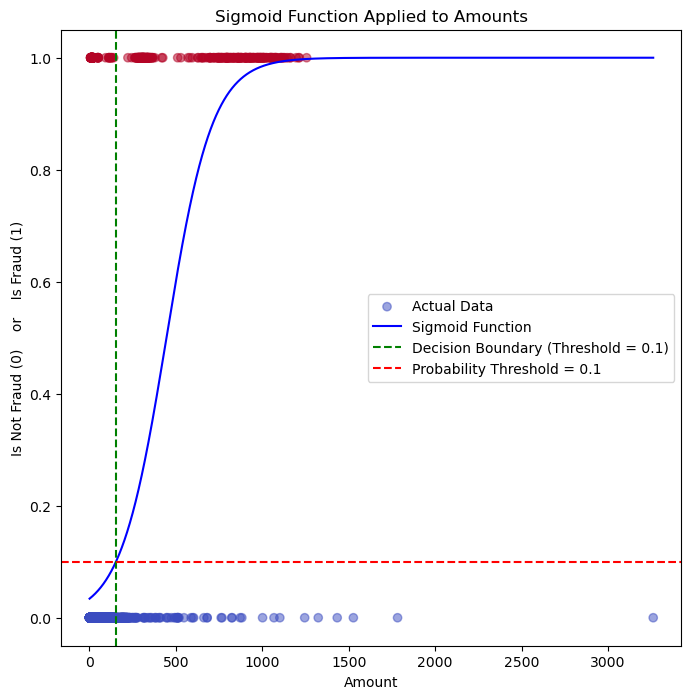

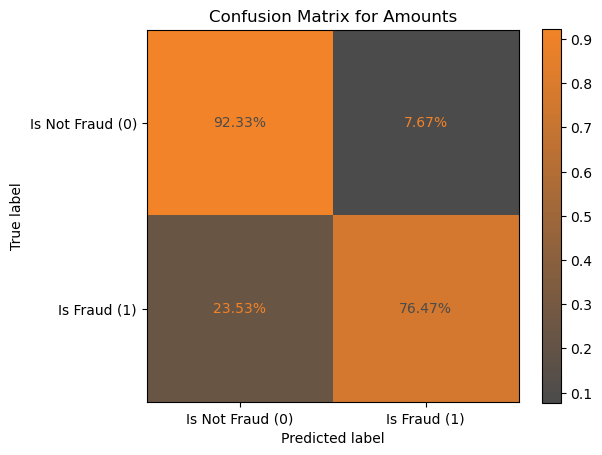

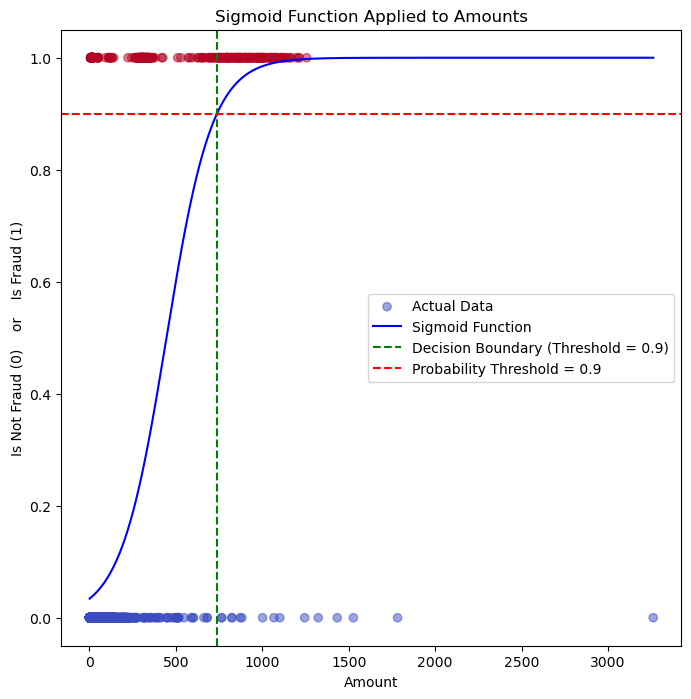

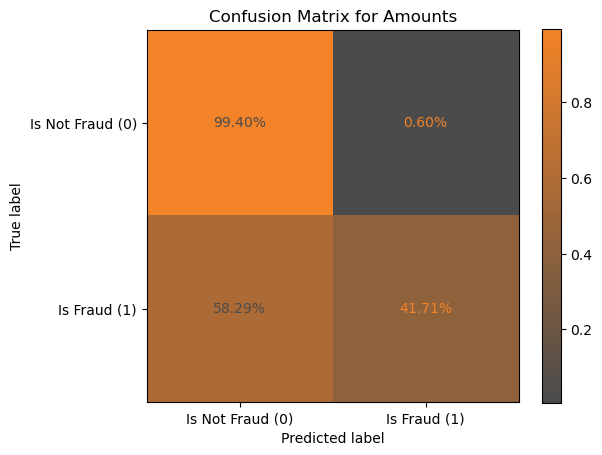

In [20]:
logisticRegression(['amt'], 'Amounts', 'Amount')

logisticRegression(['amt'], 'Amounts', 'Amount', 0.1)
logisticRegression(['amt'], 'Amounts', 'Amount', 0.9)

In [159]:
data = pd.read_csv('cleaned_data.csv')
df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])

df.head()

,amt,city_pop,is_fraud
0,14.37,145,1
1,966.11,145,1
2,49.61,145,1
3,295.26,145,1
4,18.17,145,1


## Next Strats

Confusion Matrix:
[[2459   62]
 [  99  257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2521
           1       0.81      0.72      0.76       356

    accuracy                           0.94      2877
   macro avg       0.88      0.85      0.86      2877
weighted avg       0.94      0.94      0.94      2877


ROC AUC Score: 0.9358506522737099


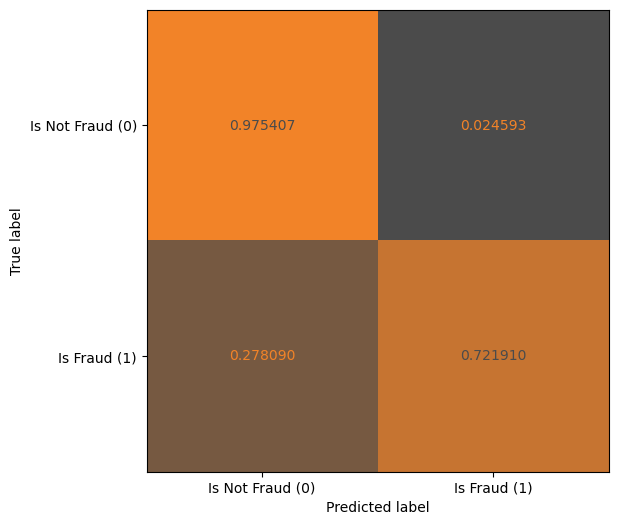

In [36]:
#Random Forest

#TODO: Could also convert some variables to factors and include them in our measurements
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load your dataset (replace with your path or DataFrame)
df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and fit Random Forest with class_weight to handle imbalance
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]



# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
cm_test = confusion_matrix(y_test, y_pred, normalize='true')
custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#4B4B4B", "#f28328"], N = 100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
fig, ax = plt.subplots(figsize=(6, 6))
im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Cross-Validation ROC AUC scores: [0.94948281 0.94701424 0.95924708 0.93124391 0.93932574]
Average CV ROC AUC: 0.9452627550324918

Confusion Matrix:
[[2459   62]
 [  99  257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2521
           1       0.81      0.72      0.76       356

    accuracy                           0.94      2877
   macro avg       0.88      0.85      0.86      2877
weighted avg       0.94      0.94      0.94      2877


Test ROC AUC Score: 0.9358506522737099


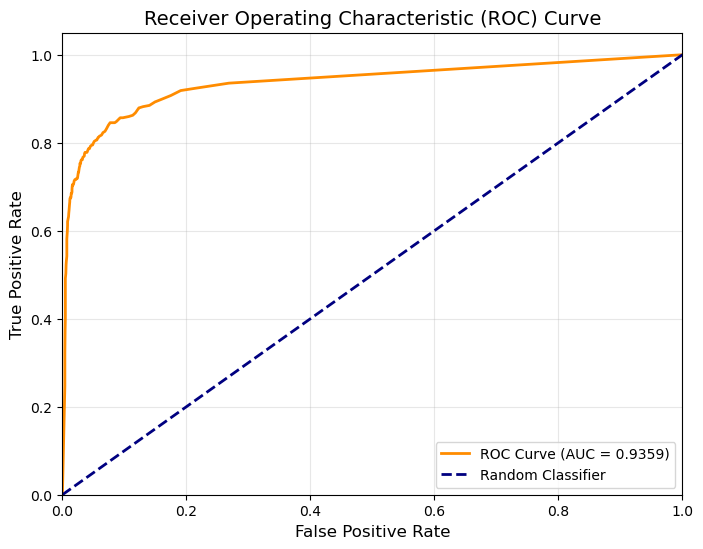

In [38]:
#Random Forest with CV
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load dataset
df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Split for final evaluation (optional if you just want CV scores)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize the model with class_weight to handle imbalance
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Cross-validation (5-fold)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print("Cross-Validation ROC AUC scores:", cv_scores)
print("Average CV ROC AUC:", cv_scores.mean())

# Fit on full training set after CV
rf.fit(X_train, y_train)

# Final evaluation on test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTest ROC AUC Score:", roc_auc_score(y_test, y_proba))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [147]:
#Including Grid Search
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load dataset
df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Set up the model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Final evaluation on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTest ROC AUC Score:", roc_auc_score(y_test, y_proba))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Confusion Matrix:
[[2354  167]
 [  61  295]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2521
           1       0.64      0.83      0.72       356

    accuracy                           0.92      2877
   macro avg       0.81      0.88      0.84      2877
weighted avg       0.93      0.92      0.93      2877


Test ROC AUC Score: 0.9545982288105755


C:\Users\sgray\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix:
[[2479   42]
 [  95  261]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2521
           1       0.86      0.73      0.79       356

    accuracy                           0.95      2877
   macro avg       0.91      0.86      0.88      2877
weighted avg       0.95      0.95      0.95      2877


ROC AUC Score: 0.9432458361003525


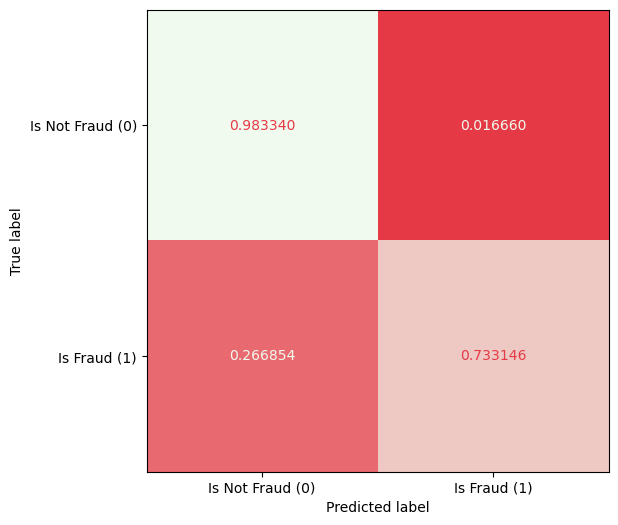

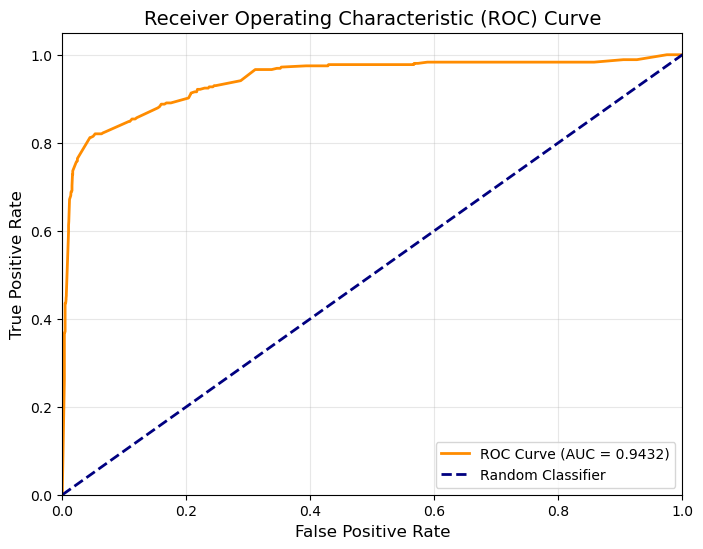

In [48]:
#Adaboosted Decision Stumps, better
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Base estimator: decision stump
stump = DecisionTreeClassifier(max_depth=1)

# AdaBoost classifier
ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME.R',  # SAMME.R uses probabilities and is often better
    random_state=42
)

# Train model
ada.fit(X_train, y_train)

# Predictions
y_pred = ada.predict(X_test)
y_proba = ada.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

cm_test = confusion_matrix(y_test, y_pred, normalize='true')
custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#E63946", "#F1FAEE"], N = 100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
fig, ax = plt.subplots(figsize=(6, 6))
im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_


# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\sgray\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}

Confusion Matrix:
[[2479   42]
 [  95  261]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2521
           1       0.86      0.73      0.79       356

    accuracy                           0.95      2877
   macro avg       0.91      0.86      0.88      2877
weighted avg       0.95      0.95      0.95      2877


Test ROC AUC Score: 0.9459027316607909


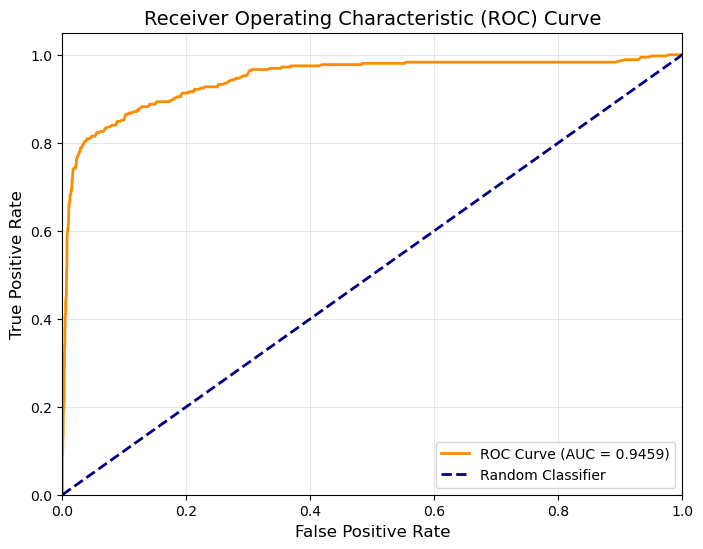

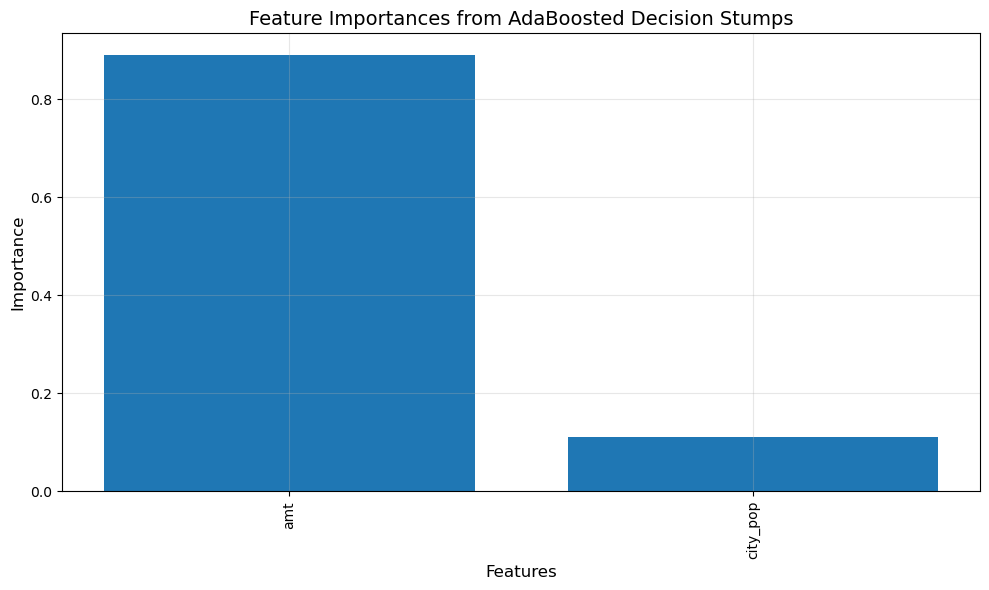

Best hyperparameters found: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}


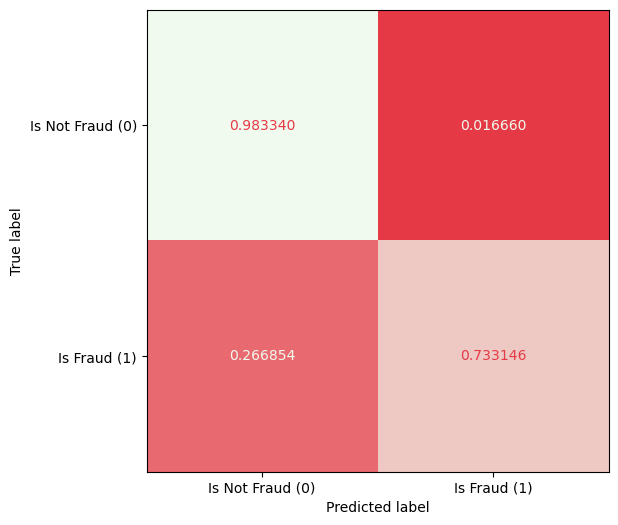

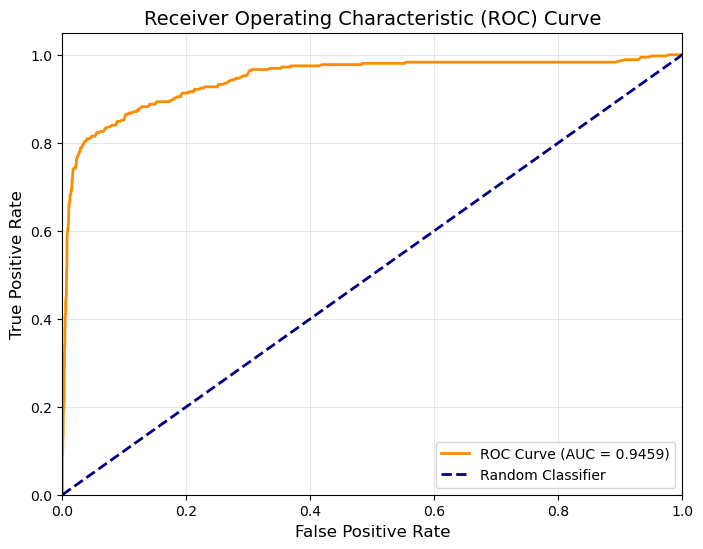

In [16]:
#AdaBoost Stump with CV
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load dataset
df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Base estimator: decision stump
stump = DecisionTreeClassifier(max_depth=1)

# AdaBoost classifier setup
ada = AdaBoostClassifier(estimator=stump, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_ada = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_ada.predict(X_test)
y_proba = best_ada.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTest ROC AUC Score:", roc_auc_score(y_test, y_proba))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from best AdaBoost model
importances = best_ada.feature_importances_

# Get feature names
feature_names = X.columns

# Sort importances
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from AdaBoosted Decision Stumps", fontsize=14)
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("Best hyperparameters found:", grid_search.best_params_)


cm_test = confusion_matrix(y_test, y_pred, normalize='true')
custom_cmap = LinearSegmentedColormap.from_list("custom_map", ["#E63946", "#F1FAEE"], N = 100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Is Not Fraud (0)", "Is Fraud (1)"])
fig, ax = plt.subplots(figsize=(6, 6))
im = disp.plot(cmap=custom_cmap, ax=ax, values_format="f", colorbar=False).im_


# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [143]:
#Bagging Classifier, about as good as Random Forest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]


# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Base estimator: full decision tree (you can also use stumps or others)
base_estimator = DecisionTreeClassifier()

# Bagging classifier
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=50,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Fit model
bagging_model.fit(X_train, y_train)

# Predictions
y_pred = bagging_model.predict(X_test)
y_proba = bagging_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[2463   58]
 [  94  262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2521
           1       0.82      0.74      0.78       356

    accuracy                           0.95      2877
   macro avg       0.89      0.86      0.87      2877
weighted avg       0.95      0.95      0.95      2877


ROC AUC Score: 0.9375554332372118


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'estimator__max_depth': 5, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 100}

Confusion Matrix:
[[2296  225]
 [  55  301]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2521
           1       0.57      0.85      0.68       356

    accuracy                           0.90      2877
   macro avg       0.77      0.88      0.81      2877
weighted avg       0.93      0.90      0.91      2877


Test ROC AUC Score: 0.9485050296609603


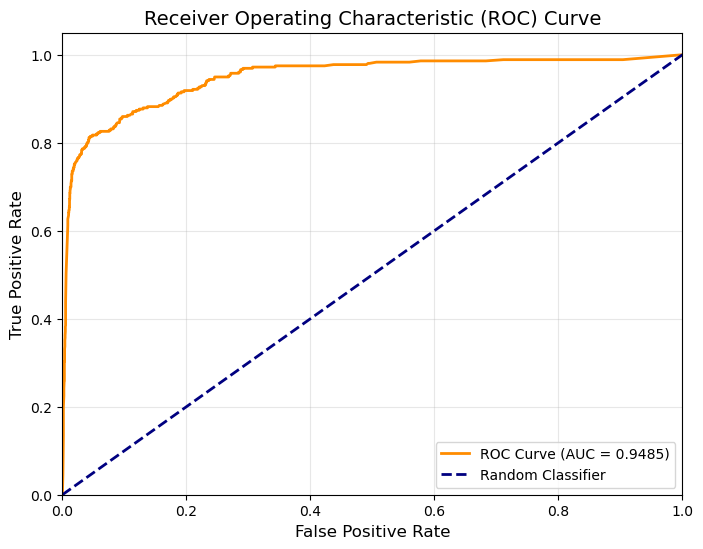

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('cleaned_data.csv')  # assuming it's the common dataset
df = df.drop(columns = ["Unnamed: 0", "trans_date_trans_time", "merchant", "category", "city", "state",  "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"])
# Features and target
X = df.drop("is_fraud", axis=1)  # "Class" is usually the target: 0 = legit, 1 = fraud
y = df["is_fraud"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Base estimator
tree = DecisionTreeClassifier(class_weight='balanced')

# Bagging classifier
bagging = BaggingClassifier(estimator=tree, random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0],
    'estimator__max_depth': [None, 5, 10]  # Updated for scikit-learn >=1.2
}

# Grid search
grid_search = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_bag = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate
y_pred = best_bag.predict(X_test)
y_proba = best_bag.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTest ROC AUC Score:", roc_auc_score(y_test, y_proba))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_proba = best_bag.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# Dylan's Stuff

Loading and preprocessing data...


Enter the name of the dataset:  cleaned_data.csv


Data loaded successfully!
Initial data shape: (14383, 16)

First few rows of raw data:

Combining all derived features...

Creating age feature...

Creating distance feature...

Creating time-based features...

Creating location-based features...


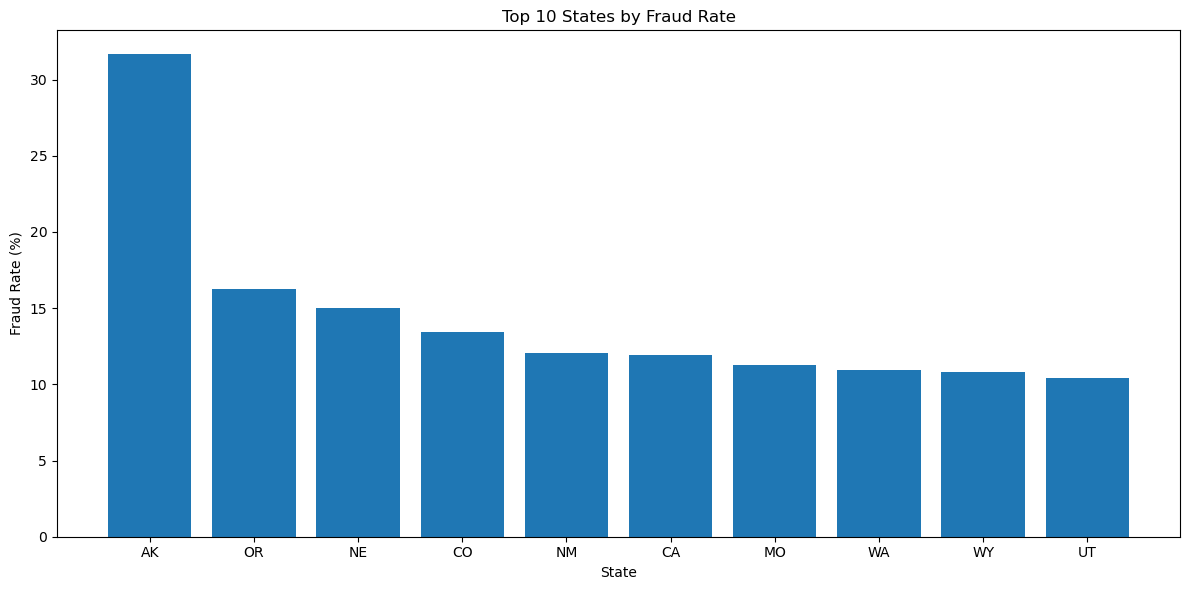


Added 11 new features:
  - Unnamed: 0
  - age
  - distance_km
  - trans_hour
  - trans_dayofweek
  - trans_month
  - trans_day
  - is_weekend
  - time_period
  - city_pop_bin
  - high_risk_state
Preprocessed data shape: (14383, 26)

First few rows of preprocessed data:
   Unnamed: 0 trans_date_trans_time                          merchant  \
0           0      04-01-2019 00:58  "Stokes, Christiansen and Sipes"   
1           1      04-01-2019 15:06                      Predovic Inc   
2           2      04-01-2019 22:37                   Wisozk and Sons   
3           3      04-01-2019 23:06                    Murray-Smitham   
4           4      04-01-2019 23:59                        Friesen Lt   

         category     amt   city state      lat      long  city_pop  ...  \
0     grocery_net   14.37  Wales    AK  64.7556 -165.6723       145  ...   
1    shopping_net  966.11  Wales    AK  64.7556 -165.6723       145  ...   
2        misc_pos   49.61  Wales    AK  64.7556 -165.6723     

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
import datetime
from math import *

# Define Sigmoid Function
def sigmoid(z):
    """
    Compute the sigmoid of z (works for both arrays and scalar values)
    """
    return 1 / (1 + np.exp(-np.array(z, dtype=float)))

# Define Cost Function (keeping your original function)
def compute_cost_logistic(y, y_hat):
    m = len(y) # Number of training examples
    epsilon = 1e-5 # Small constant to prevent log being 0
    # Compute the logistic regression cost
    cost = (-1 / m) * (y.T.dot(np.log(y_hat + epsilon)) + (1 - y).T.dot(np.log(1 - y_hat + epsilon)))
    return cost

# Optimization function (keeping your original function)
def optimize_theta(theta, X, y):
    # Define the objective function to minimize
    def objective_function(t):
        # Calculate the predicted probabilities (y_hat)
        y_hat = sigmoid(X.dot(t))
        # Compute the cost with current theta, y, and y_hat
        return compute_cost_logistic(y, y_hat)
    
    # Run the optimizer with the objective function
    result = minimize(objective_function, theta, method='TNC', jac=False)
    return result.x, result.fun

def load_data(file_path):
    """
    Load the fraud detection dataset.
    
    Parameters:
    -----------
    file_path : str
        Path to the dataset CSV file
    
    Returns:
    --------
    df : DataFrame
        The loaded dataset
    """
    print("Loading data...")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    
    return df

def create_age_feature(df):
    """
    Create customer age feature from date of birth (dob).
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with 'dob' column
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added age feature
    """
    print("\nCreating age feature...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Convert DOB to datetime
    df['dob'] = pd.to_datetime(df['dob'], format='%m-%d-%Y', errors='coerce')
    
    # Extract transaction date from transaction datetime
    # First convert the transaction date to datetime
    df['trans_date'] = pd.to_datetime(df['trans_date_trans_time'], format='%m-%d-%Y %H:%M', errors='coerce')
    
    # Calculate age at time of transaction
    # If transaction date is not available, use a reference date (e.g., 2019-01-01)
    ref_date = pd.to_datetime('2019-01-01')  # Assuming all transactions are around 2019
    
    # For transactions with valid dates, use those dates
    df['age'] = np.where(
        df['trans_date'].notna(),
        (df['trans_date'] - df['dob']).dt.days / 365.25,
        (ref_date - df['dob']).dt.days / 365.25
    )
    
    # Handle any anomalies (negative ages, extremely high ages)
    df['age'] = df['age'].clip(lower=18, upper=100)  # Assuming customers are between 18 and 100
    
    return df

def create_distance_feature(df):
    """
    Calculate distance between customer location and merchant location.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with lat, long, merch_lat, merch_long columns
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added distance feature
    """
    print("\nCreating distance feature...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Haversine formula to calculate distance between two points on the Earth
    def haversine_distance(lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # Haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371  # Radius of earth in kilometers
        return c * r
    
    # Apply the haversine function to calculate distance
    df['distance_km'] = df.apply(
        lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long'])
        if pd.notna(row['lat']) and pd.notna(row['long']) and pd.notna(row['merch_lat']) and pd.notna(row['merch_long'])
        else np.nan, 
        axis=1
    )
    
    return df

def create_time_features(df):
    """
    Extract time-based features from transaction datetime.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with 'trans_date_trans_time' column
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added time-based features
    """
    print("\nCreating time-based features...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Convert transaction datetime to proper datetime object
    df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%m-%d-%Y %H:%M', errors='coerce')
    
    # Extract various time components
    df['trans_hour'] = df['trans_datetime'].dt.hour
    df['trans_dayofweek'] = df['trans_datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['trans_month'] = df['trans_datetime'].dt.month
    df['trans_day'] = df['trans_datetime'].dt.day
    
    # Create weekend flag (0=weekday, 1=weekend)
    df['is_weekend'] = (df['trans_dayofweek'] >= 5).astype(int)
    
    # Define time of day periods
    df['time_period'] = pd.cut(
        df['trans_hour'], 
        bins=[0, 6, 12, 18, 24], 
        labels=['night', 'morning', 'afternoon', 'evening'],
        include_lowest=True
    )
    
    
    return df

def create_location_features(df):
    """
    Create features based on location data.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with location columns
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added location-based features
    """
    print("\nCreating location-based features...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Create city population bins
    df['city_pop_bin'] = pd.cut(
        df['city_pop'], 
        bins=[0, 1000, 10000, 100000, 1000000, float('inf')],
        labels=['very_small', 'small', 'medium', 'large', 'very_large']
    )
    
    # Analyze high-risk states (if state column is available)
    if 'state' in df.columns:
        # Get states with at least 100 transactions
        state_counts = df['state'].value_counts()
        valid_states = state_counts[state_counts >= 100].index
        
        # Calculate fraud rate by state for valid states
        state_fraud = df[df['state'].isin(valid_states)].groupby('state')['is_fraud'].mean() * 100
        state_fraud = state_fraud.sort_values(ascending=False)
        
        # Plot top 10 states by fraud rate
        plt.figure(figsize=(12, 6))
        plt.bar(state_fraud.index[:10], state_fraud.values[:10])
        plt.title('Top 10 States by Fraud Rate')
        plt.xlabel('State')
        plt.ylabel('Fraud Rate (%)')
        plt.tight_layout()
        plt.show()
        
        # Create high-risk state flag
        high_risk_states = state_fraud[state_fraud > 15].index.tolist()  # States with >15% fraud rate
        df['high_risk_state'] = df['state'].isin(high_risk_states).astype(int)
    
    return df

def combine_all_features(df):
    """
    Apply all feature engineering steps and create a final dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    
    Returns:
    --------
    df_final : DataFrame
        Final dataframe with all derived features
    """
    print("\nCombining all derived features...")
    
    # Apply each feature engineering function
    df = create_age_feature(df)
    df = create_distance_feature(df)
    df = create_time_features(df)
    df = create_location_features(df)
    
    # Remove intermediate columns
    cols_to_drop = ['trans_datetime', 'trans_date']
    df_final = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)
    
    # List all new features
    original_cols = set(['', 'trans_date_trans_time', 'merchant', 'category', 'amt', 
                         'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 
                         'trans_num', 'merch_lat', 'merch_long', 'is_fraud'])
    new_cols = [col for col in df_final.columns if col not in original_cols]
    
    print(f"\nAdded {len(new_cols)} new features:")
    for col in new_cols:
        print(f"  - {col}")
    
    # Return the final dataframe
    return df_final



# Function to compute evaluation metrics
def evaluate_model(y_true, y_pred, y_prob=None):
    """
    Compute and print evaluation metrics
    """
    # Accuracy
    accuracy = np.mean(y_pred == y_true)
    
    # Create confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    
    # If probabilities are provided, compute ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Return values for plotting
        return accuracy, precision, recall, f1, roc_auc, fpr, tpr
    
    return accuracy, precision, recall, f1, None, None, None



# Load and explore the data
print("Loading and preprocessing data...")

# Read in and process Data
csv_name = input("Enter the name of the dataset: ") # Dataset needs to be in local directory
df = pd.read_csv(csv_name)
print("Data loaded successfully!")


# Print initial info
print(f"Initial data shape: {df.shape}")
print("\nFirst few rows of raw data:")

df = combine_all_features(df)

# Remove unnecessary columns
#drop_cols = ['trans_date_trans_time', 'trans_num', 'dob']
#df = df.drop(columns=drop_cols)

# Print preprocessed data info
print(f"Preprocessed data shape: {df.shape}")
print("\nFirst few rows of preprocessed data:")
print(df.head())



In [6]:
df = df.drop(columns = "Unnamed: 0")
df.head()

create_time_features(df)

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,...,age,distance_km,trans_hour,trans_dayofweek,trans_month,trans_day,is_weekend,time_period,city_pop_bin,high_risk_state
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",...,79.55373,109.285552,0.0,0.0,4.0,1.0,0,night,very_small,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",...,79.55373,79.856896,15.0,0.0,4.0,1.0,0,afternoon,very_small,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",...,79.55373,66.807915,22.0,0.0,4.0,1.0,0,evening,very_small,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",...,79.55373,39.636227,23.0,0.0,4.0,1.0,0,evening,very_small,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",...,79.55373,77.611529,23.0,0.0,4.0,1.0,0,evening,very_small,1


In [8]:
from sklearn.pipeline import Pipeline

# Load the sklearn selector doing both "Forward" and "Backword" selections
from sklearn.feature_selection import SequentialFeatureSelector 


# Data splitting
print("\nSplitting data into training and testing sets...")
# Check for and handle any missing values before splitting
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in the dataset:")
    print(missing_values[missing_values > 0])
    
    
    print("Missing values have been handled.")
    
# Split data into features and target variable
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8)

# Display the number of samples in each set
print(f"Number of samples in Training Set : {np.size(X_train)}\n")
print(f"Number of samples in Testing Set : {np.size(X_test)}\n")





# Transform Training and Testing data
# Simple preprocessing: handle categorical features and scale numerical features
# Identify categorical and numerical columns
categorical_columns = ['merchant', 'category', 'city', 'state', 'job']
numerical_columns = [col for col in X.columns if col not in categorical_columns]




# Declare a model:
model = LogisticRegression()

# Construct the Pipeline with scaler, feature_selection technique, and model fitting
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", SequentialFeatureSelector(model, direction = "forward", n_features_to_select = 3)),
    ("model", model)
])

# Perform feature selection and obtain selected features for model fitting and testing:
# Remember that for logistic regression, since it uses GD, we need to standardize the features for faster convergence.
X_train_scaled_selected = pipe.fit(X_train, y_train) 

# Train the model with selected features:
model.fit(X_train_scaled_selected, y_train)


# Initialize theta
print("\nInitializing theta and running optimization...")
initial_theta = np.zeros(X_train_array.shape[1])


# Compute Z-Values with initial theta
z_values = np.dot(X_train_array, initial_theta)

# Calculate y_hat using the initial theta values for the training set
y_hat_train = sigmoid(z_values)  

# Compute the cost to two decimal places
cost_logistic_train = np.round(compute_cost_logistic(y_train.values, y_hat_train), 2)

# Print the computed cost for the training set
print(f"Initial cost (logistic) with zeros for theta: {cost_logistic_train}")

# Now run the optimization to find the best theta
print("\nOptimizing theta parameters...")
theta_optimized, cost_optimized = optimize_theta(initial_theta, X_train_array, y_train.values)



Splitting data into training and testing sets...

Missing values in the dataset:
dob                 9793
age                 9793
trans_hour         10050
trans_dayofweek    10050
trans_month        10050
trans_day          10050
time_period        10050
dtype: int64
Missing values have been handled.
Number of samples in Training Set : 276144

Number of samples in Testing Set : 69048



ValueError: could not convert string to float: '13-01-2019 15:04'